# Control the GoPro camera remotely

ArdavanBidgoli <br />
CMU School of Architecture <br />
Robotic Plastering Project <br />
GoPro remote controller <br />
Tested with/for: <br />
Tensorflow 0.12.1 <br />
OpenCV 3.2.0-dev <br />

## All importing and file setup

In [5]:
###############################################################################
# All libraries and importings
# For camera functionalities
#from goprohero import GoProHero
import urllib.request

# general purpose libraries
import ast
import time

# for image processing 
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# for wifi
import subprocess


# default wifi Password:
# goproCamera
# goproPassword
###############################################################################

## Main claesses
There are three main classes in this code: checkWifi, GoProCamera, and CameraCalibrarion

### Check WiFi network

In [6]:
class checkWifi(object):
    # aclass to find all the wifi netwroks with gopro in their name
    goproWifiFullData = []
    goproWifi = []

    def __init__ (self):
        # cleans the currently available list
        checkWifi.goproWifi = []
        # generates and prints report
        checkWifi.refresh()
        print ("GoPro wifi(s) available:")
        for data in checkWifi.goproWifi:
            print ("SSID: "+data[1])
    
    def refresh():
        # checks for all wifi netwroks available
        goproWifiFullData = []
        goproWifi = []
        results = subprocess.check_output(["netsh", "wlan", "show", "network"])
        new = results.splitlines()
        for i in range (len(new)):
            ln = new[i].decode("ascii")
            tmp = ln.split(" ")
            # searches to find gopro keyword in the wifi name
            for word in tmp:
                word = word.lower()
                if (word.find("gopro") != -1):
                    goproWifi.append (str(new[i])[2:])
                    for j in range (4):
                        goproWifiFullData.append (str(new[i+j])[2:])
        checkWifi.goproWifiFullData = goproWifiFullData
        # formats data
        for temp in goproWifi:
            temp = temp.split(":")
            temp_ = []
            for data in temp:
                data = data.strip()
                data = data.replace("\'", "")
                temp_.append(data)
            checkWifi.goproWifi.append(temp_)

    def isConnectedToGoproWifi(wifiName= "gopro"):
        data = subprocess.check_output("netsh wlan show interfaces")
        data = str(data)
        data = data.lower()
        if wifiName in data:
            print ("You are connected to a GoPro wifi network")
            return True
        print ("You are not connected to a GoPro wifi network, please use windows wifi setting to connect to the camera")
        return False

### GoPro Camera Class

In [7]:
class GoProCamera(object):
    # a class to handle one goPro camera conected to WiFi
    # This is the address that iamges and videos are stored
    mainPath ='http://10.5.5.9/videos/DCIM/100GOPRO/' 
    # iamge names are coming after this tag
    LinkTag = "<a class=\"link\" href=\""

    def __init__(self, password = 'letMeIn2016'):
        # the password is for my GoPro camera
        # creates an instance of the camera
        self.camera = GoProHero(password)
        self.status = dict()
        self.setting = dict()
        self.videoAddress = []
        self.imageAddress = []
        self.images = []
        self.videos = []
        self.imageNames = []
        self.images = []
        # updates the media list on the camera
        GoProCamera.statusUpdate(self) 

    def statusUpdate(self):
        # reads cameras' status report url
        result = []
        mainPath ='http://10.5.5.9/gp/gpControl/status' 
        httpData = urllib.request.urlopen(mainPath)
        httpRaw = httpData.read()
        # reformat data
        httpStr = str(httpRaw)
        httpStr.replace("\\n", "")
        # finds keywords, breaks the unneccessary characters and 
        # reformat as dict
        index1 = httpStr.find("status")
        index2 = httpStr.find("settings")
        tempStatus = "{"+httpStr[index1+11:index2-4]
        status = ast.literal_eval(tempStatus)
        tempSetting = httpStr[index2+10:-4]
        setting = ast.literal_eval(tempSetting)
        # adding data to the output result
        result.append(status)
        result.append(setting)
        # adding to the object data
        self.status = status
        self.setting = setting
        return (result)

    def statusReport(self):
        # generates a status report from the camera
        GoProCamera.statusUpdate(self)
        self.statusReportData = []
        # key words from the camera documentation here:
        # https://github.com/KonradIT/goprowifihack/blob/master/HERO4/CameraStatus.md
        reportData =    [("Battery level", "2"), ("Current Mode", "43"),
                        ("Curr. SubMode", "44"), ("Image Count", "38")]
        keyWords= [["","Full","Half","Low", "Charging"],
                    ["Video","Photo","Multishot","Not","PlayBack", "Setup"],
                    [["Video","TL Video", "Video+Photo"],
                    ["Single Pic", "Continuous", "NightPhoto"],
                    ["Burst", "TimeLapse","NightLapse"]], (list(range(100)))]
        #prints the report
        print ("Camera status report:")
        print ("---------------------")
        for i in range(len(reportData)):
            keywordsIndex = int(self.status[reportData[i][1]])
            if i == 2 :
                currentMode = self.status["43"]
                if currentMode < 4:
                    try:
                        temp = reportData[i][0]+":\t"+ str(keyWords[i][currentMode][keywordsIndex])
                    except:
                        temp = reportData[i][0]+":\t"+ ("Couldn't be retrived")                    
            else:
                try:
                    temp = reportData[i][0]+":\t"+ str(keyWords[i][keywordsIndex])
                except:
                    temp = reportData[i][0]+":\t"+ ("Couldn't be retrived")
            print (temp)
        print ("---------------------")
        return (self.statusReportData)

    def setforImage(self, calibration = False):
        print("Set for image")
        # update camera data
        GoProCamera.statusUpdate(self)
        counter = self.status["38"]
        # set autoOff to off, main mode to photo, sub-mode to single photo, 
        # resolution to 12MP, and makes a test shot, and delete it! 
        # commands came from here:
        # https://github.com/KonradIT/goprowifihack/blob/master/HERO4/WifiCommands.md
        setupCodes = [  ('autoOff', 'http://10.5.5.9/gp/gpControl/setting/59/0'),
                        ('mainMode','http://10.5.5.9/gp/gpControl/command/mode?p=1'),
                        ('subMode', 'http://10.5.5.9/gp/gpControl/command/sub_mode?mode=1&sub_mode=0'),
                        ('res', 'http://10.5.5.9/gp/gpControl/setting/17/0'),
                        ('trigger', 'http://10.5.5.9/gp/gpControl/command/shutter?p=1')]
        if (calibration):
            setupCodes[3] = ('res', 'http://10.5.5.9/gp/gpControl/setting/17/3')
        for code in setupCodes:
            # calls for urls and activate the settings
            a,url = code
            urllib.request.urlopen(url)
        time.sleep(1)
        GoProCamera.statusUpdate(self)
        # house keeping and updating the status of camera
        if  counter != (self.status["38"]):
            # delete the test picture
            urllib.request.urlopen('http://10.5.5.9/gp/gpControl/command/storage/delete/last')
            self.imageMode = True
            return self.imageMode
        else:
            self.imageMode = False
            return self.imageMode


    def trigger(self):
        # takes one picture if the camera is in pic mode
        # commands came from here:
        # https://github.com/KonradIT/goprowifihack/blob/master/HERO4/WifiCommands.md
        self.imageMode = True
        if (self.imageMode):
            print ("Taking a shot!")
            try:
                urllib.request.urlopen('http://10.5.5.9/gp/gpControl/command/shutter?p=1')
            
            except:
                pass
            GoProCamera.retriveImages(self,1,"lastFrame.jpg")
        print ("Shot taken")

    def retriveImages(self, number = 1,name = None):
        # retrive a list of images from the camera
        result = []
        indexList = list(range(number))
        GoProCamera.updateList(self)
        for i in indexList:
            address = self.imageAddress[-abs(i+1)]
            if  (name != None and number ==1 ):
                photoName = name
            else:
                photoName = "Frame%d.jpg" %i
            self.imageNames.append(photoName)
            photo = urllib.request.urlretrieve(address,photoName)
            result.append(cv2.imread(photoName))
            self.images.append(result)
            print ("Image %s is saved" %photoName)
        return result

    def showBufferedImages(self, numbers = 1):
        print ("Showing the image")
        if (len(self.imageNames) < numbers):
            print ("You are asking for more images than what you have buffered!") 
            numbers = len(self.imageNames)
        for i in range (numbers):
            index = -i-1
            newImage = cv2.imread(self.imageNames[index])
            display(newImage)

    def updateList(self):
        imageNames, videoNames= [],[]
        imageAddress,videoAddress = [],[]
        httpData = response = urllib.request.urlopen(GoProCamera.mainPath)
        httpRaw = httpData.read()
        httpStr = str(httpRaw)
        httpSplitted = httpStr.split(GoProCamera.LinkTag)
        for name in httpSplitted: 
            temp = name[:12]
            splitted = temp.split(".")
            if len(splitted) == 2:
                if splitted[1] == "JPG":
                    imageNames.append(temp)
                    imageAddress.append(GoProCamera.mainPath+temp)
                if splitted[1] == "MP4":
                    videoNames.append(temp)
                    videoAddress.append(GoProCamera.mainPath+temp)
        self.images = imageNames
        self.videos = videoNames        
        self.imageAddress = imageAddress
        self.videoAddress = videoAddress

### Camera Calibration
For this class, we need a video feed or 20 images from the checker board

In [8]:
##########################################################################################
# Camera Calibration class
##########################################################################################

class CameraCalibrarion(object):
    def __init__(self, camera = None,  fileName = "Calibration_Image",
         n_boards = 20, calibrate = True, captureImages = False):
        #self.fileName = []
        self.fileName = fileName
        #self.size = size
        # number of images
        self.n_boards = n_boards
        # number of squares in the board:
        self.board_w = 9
        self.board_h = 6
        # board size in cm
        self.board_dim = 25
        #image resolution
        self.image_size = (1920,1080)
        self.crop = 0.5
        self.camera = camera
        # names:
        self.calibrationData = 'calibration_data'

        if (captureImages):
            if (self.camera == None):
                self.camera = GoProCamera()
                self.captureImages()

        if (calibrate):
            # operations
            self.ImageProcessing()
            self.calibration()
            self.saveCalibrationData()
            self.undistortImages(True)

    def calibrate (self):
        self.ImageProcessing()
        self.calibration()
        self.saveCalibrationData()
        self.undistortImages(True)

    def captureImages(self):
        # generates status report
        self.camera.statusReport()
        # change setting for 12MP single image 
        self.camera.setforImage(calibration = True)
        for i in range (self.n_boards):
            # takes image(s)
            self.camera.trigger()
            name = self.fileName + str(i+1) + '.png'
            self.camera.retriveImages(1, name)
            # shows bufferred image(s)
            camera.showBufferedImages()
        self.camera.setforImage()

    def ImageProcessing(self):
        board_n = self.board_w * self.board_h
        opts = []
        ipts = []
        npts = np.zeros((self.n_boards, 1), np.int32)
        intrinsic_matrix = np.zeros((3, 3), np.float32)
        distCoeffs = np.zeros((5, 1), np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    
        # prepare object points based on the actual dimensions of the calibration board
        # like (0,0,0), (25,0,0), (50,0,0) ....,(200,125,0)
        objp = np.zeros((self.board_h*self.board_w,3), np.float32)
        objp[:,:2] = np.mgrid[0:(self.board_w*self.board_dim):\
            self.board_dim,0:(self.board_h*self.board_dim):self.board_dim].T.reshape(-1,2)

        #Loop through the images.  Find checkerboard corners and save the data to ipts.
        for i in range(1, self.n_boards + 1):
        
            #Loading images
            print ('Loading... Calibration_Image' + str(i) + '.png' )
            image_ = cv2.imread(self.fileName + str(i) + '.png')
            # resizing image
            r = 1920.0 / image_.shape[1]
            dim = (1920, int(image_.shape[0] * r))
             
            # perform the actual resizing of the image and show it
            image = cv2.resize(image_, dim, interpolation = cv2.INTER_AREA)
            #cv2.imshow("resized", resized)
            cv2.waitKey(0)
            
            print ("1")
            #Converting to grayscale
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            print ("2")
            #Find chessboard corners
            found, corners = cv2.findChessboardCorners(grey_image, \
                (self.board_w,self.board_h),cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)
            print ("3")
            if found == True:

                #Add the "true" checkerboard corners
                opts.append(objp)
                
                #Improve the accuracy of the checkerboard corners 
                # found in the image and save them to the ipts variable.
                cv2.cornerSubPix(grey_image, corners, (20, 20), (-1, -1), criteria)
                print ("4")
                ipts.append(corners)
        self.opts = opts
        self.ipts = ipts
        self.grey_image = grey_image
        print ('')
        print ('Finished processes images.')
 

    def calibration(self):
        print ('Running Calibrations...')
        print(' ')
        self.ret, self.intrinsic_matrix, self.distCoeff, self.rvecs, self.tvecs = \
            cv2.calibrateCamera(self.opts, self.ipts, self.grey_image.shape[::-1],None,None)

    def saveCalibrationData(self):
        print ('Saving data file...')
        np.savez(self.calibrationData, distCoeff=self.distCoeff, intrinsic_matrix= self.intrinsic_matrix)
        print ('Calibration complete')
            #Calculate the total reprojection error.  The closer to zero the better.
        self.tot_error = 0
        for i in range(len(self.opts)):
            self.imgpoints2, _ = cv2.projectPoints(self.opts[i], self.rvecs[i],\
                        self.tvecs[i], self.intrinsic_matrix, self.distCoeff)
            error = cv2.norm\
            (self.ipts[i],self.imgpoints2, cv2.NORM_L2)/len(self.imgpoints2)
            self.tot_error += error
        print ("total reprojection error: ", self.tot_error/len(self.opts))

    def loadCalibrationData(self, fileName = None ):
        print ("reading calibration file")
        if fileName == None:
            calibrationDataFile = np.load(self.calibrationData+".npz")
        else:
            calibrationDataFile = np.load(fileName+".npz")
        print (calibrationDataFile.files)
        self.distCoeff = calibrationDataFile['distCoeff']
        self.intrinsic_matrix = calibrationDataFile['intrinsic_matrix']

    def undistortImages(self, saveImage = False):
        print ("saving undistorted images")
        #Undistort Images
        #Scale the images and create a rectification map.
        newMat, ROI = cv2.getOptimalNewCameraMatrix\
            (self.intrinsic_matrix, self.distCoeff, self.image_size, alpha = self.crop, centerPrincipalPoint = 1)
        mapx, mapy = cv2.initUndistortRectifyMap\
            (self.intrinsic_matrix, self.distCoeff, None, newMat, self.image_size, m1type = cv2.CV_32FC1)                      
        for i in range(1, self.n_boards + 1):
            #Loading images
            print ('Loading... Calibration_Image' + str(i) + '.png' )
            image = cv2.imread(self.fileName + str(i) + '.png')
            # undistort
            dst = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)
            if (saveImage):
                name = self.fileName + str(i) + '_undistorted.png'
                print ("Saving... %s" %name)
                cv2.imwrite( name, dst );

                

### Helper functions 

In [9]:
class surfaceScan(object):
    def __init__(self):
        # Setup values
        self.minArea = 20
        self.maxArea = 3000
        # every surface with this amount of error will fail
        self.rejectRatio = 0.01

    def readImage(self, image=None):
        if (image != None):img = image
        else: img = cv2.imread('01.jpg')


def display(image):
    if (type(image) != list):
        r= 100.0 / image.shape[1]
        dim = (100, int(image.shape[0]*r))
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA )
        cv2.imshow("preview", resized)
        #cv2.imshow("w", image)
    else:
        for img in image:
            r= 100.0 / image.shape[1]
            dim = (100, int(image.shape[0]*r))
            resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA )
            cv2.imshow("preview", resize)

    k = cv2.waitKey(0)
    if k == 32:   # wait for a specific key to exit
            cv2.destroyAllWindows()

def calibrateThisCamera(camera):
    fileName = "Calibration_Image"
    calCamera = CameraCalibrarion(camera = camera,  fileName =fileName , n_boards = 5, calibrate = False, captureImages = True)
    calCamera.captureImages()
    calCamera.calibrate()
    calCamera.saveCalibrationData()
    return fileName

def testThisCamera(camera):
    # generates status report
    camera.statusReport()
    # change setting for 12MP single image 
    camera.setforImage()
    # takes image(s)
    camera.trigger()
    # shows bufferred image(s)
    # camera.showBufferedImages()
#################################

## Test the code

In [10]:
# makes a report of available GoPro wifi
checkWifi()
# To add: it should check for camera available
# initiates an instance of gopro camera
if (checkWifi.isConnectedToGoproWifi()):
    camera = GoProCamera()
    testThisCamera(camera)
    # to calibrate the camera by taking a series of pictures 
    #calibrateThisCamera(camera)

else:
    print ("Not connected to camera wifi!")

GoPro wifi(s) available:
SSID: goproQwert2017
You are connected to a GoPro wifi network


NameError: name 'GoProHero' is not defined

In [12]:
img = cv2.imread('lastFrame.jpg')

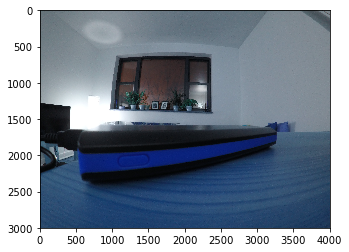

In [13]:
imgplot = plt.imshow(img)

In [14]:
cv2.imwrite('gray_image.png',img)

True